### 説明

- 以前扱ったSARIMAなどのモデリングは「データが生まれた背景を知ること」に重きを置いた方法**（AIの結果を元に、人間が判断）**
- ディープラーニングは「精度の良い予測」に重きを置いた方法**（AIがすべて判断）**


- 時系列のディープラーニングには通常RNN（Recurrent neural network）が使用される
- その中でも、今回はより高精度が出やすいと言われるLSTM(Long Short-Term Memory)を使用
- 大事な部分は覚えて、どうでも良い部分は忘れる


### ライブラリ&データの準備

In [1]:
# https://www.youtube.com/watch?v=y-XvMZq33c4&list=PL_tQOEJCWOE5aTQDXRm3Y3LY_s4gu2ALb&index=3
# https://analysis-navi.com/?p=3868#google_vignette

import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#データ読み込み
df = pd.read_csv("3-2_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)
#df = df[["平均気温(℃)"]] #とりあえず1つに絞る

# インデックス名を英語にリネーム
df.rename_axis('Date', axis=0, inplace=True)

# 列名を英語にリネーム
new_columns = {
    '平均気温(℃)': 'Average Temperature (℃)',
    '降水量の合計(mm)': 'Total Precipitation (mm)',
    '日照時間(時間)': 'Sunshine Duration (hours)',
    '曜日': 'Day of the Week'
}

df.rename(columns=new_columns, inplace=True)

df_week = df.resample("W").mean() #週ごとに集計

#0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # 正規化することで学習がスムーズに進みやすい
df_week_scale = pd.DataFrame(scaler.fit_transform(df_week),index=df_week.index,columns=df_week.columns)

#学習データ、試験データに分離
df_week_scale_train = df_week_scale["2010":"2018"] #学習データ
df_week_scale_test = df_week_scale["2019"] #試験データ

<ipython-input-1-6df4302e7c26>:37: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_week_scale_test = df_week_scale["2019"] #試験データ


### RNN用入力データへの整形

kerasの場合、入力データを

X = [

[[時点1におけるx1,時点1におけるx2,...],[時点2におけるx1,時点2におけるx2,...],...,[時点30におけるx1,時点30におけるx2,...]],

[[時点2におけるx1,時点2におけるx2,...],[時点3におけるx1,時点3におけるx2,...],...,[時点31におけるx1,時点31におけるx2,...]],

[[時点3におけるx1,時点3におけるx2,...],[時点4におけるx1,時点4におけるx2,...],...,[時点32におけるx1,時点32におけるx2,...]],

...

]

y = [

[[時点31におけるy]],

[[時点32におけるy]],

[[時点33におけるy]],

...

]


という形状にする必要がある。

* https://toeming.hatenablog.com/entry/2020/06/02/231233
* https://axa.biopapyrus.jp/deep-learning/rnn/

In [2]:
len(df_week_scale_train)
df_week_scale_train.values

array([[0.1321499 , 0.        , 0.66506795],
       [0.18244576, 0.00807754, 0.63189448],
       [0.09467456, 0.02100162, 0.5059952 ],
       ...,
       [0.13560158, 0.0726979 , 0.23021583],
       [0.2357002 , 0.01130856, 0.41366906],
       [0.15680473, 0.        , 0.61151079]])

In [3]:
# df_week_scale_trainのデータフレーム上記に直すための関数が以下(これをしないとdeep learningを実行できない)
# 教師データとして上記にする必要があるが関数がなかったらしい
# 教師データ(X)をスライドしていって予測する(y)

look_back = 30 #どれくらい過去まで見るか(今回だと過去30週), ここは現時点では適当(最適解ではない)

def create_input_data(data, look_back):
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))]
    y = [[] for i in range(len(raw_data))]

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]

    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)

    # ここで上のデータフレームに変形している
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))

    return y, X

y_train,X_train = create_input_data(
    data=df_week_scale_train,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=df_week_scale_test,
    look_back=look_back
)

### モデル定義

In [4]:
# 基本は試行錯誤が必要
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
# このコードは、Kerasを使用してLSTM（Long Short-Term Memory）レイヤーをニューラルネットワークモデルに追加する一般的なステップです。以下に、このコードの具体的な説明を提供します。
# return_sequences=True: 層を重ねる場合に必要なパラメータ
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# x = model.add(LSTM(ユニットをいくつ作るか(ここも現時点では適当), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model: ニューラルネットワークモデルへの参照です。このモデルはKerasで事前に定義されている必要があります。
# add(): ニューラルネットワークモデルに新しいレイヤーを追加するメソッドです。このコードではLSTMレイヤーを追加しています。
# LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])): 追加されるLSTMレイヤーの設定を指定します。
# 10: LSTMレイヤーのユニット数（ニューロン数）を指定します。この例では10個のユニットが使用されています。ユニット数はモデルの複雑性を調整するためのハイパーパラメータです。大きなユニット数はモデルの表現能力を高めますが、過学習のリスクも高くなります。
# return_sequences=True: このパラメータは、LSTMレイヤーがシーケンスを出力するかどうかを制御します。Trueに設定すると、LSTMレイヤーは出力シーケンスを返します。この設定は、LSTMレイヤーをスタックする場合やシーケンスデータを処理する場合に使用されます。
# input_shape=(X_train.shape[1], X_train.shape[2]): 入力データの形状を指定します。この例では(X_train.shape[1], X_train.shape[2])の形状のデータがLSTMレイヤーの入力として想定されています。X_train.shape[1]は時間ステップ数（シーケンスの長さ）、X_train.shape[2]は各時間ステップの特徴量の数を表します。LSTMレイヤーはシーケンスデータを効果的に処理するためのリカレントニューラルネットワークの一種です。
# このコードを実行することで、モデルにLSTMレイヤーが追加され、指定されたユニット数と入力形状に従って適切に初期化されます。このLSTMレイヤーは、シーケンスデータを入力として受け取り、そのシーケンスデータに対するニューラルネットワークの処理を実行します。

model.add(LSTM(8))
# model: ニューラルネットワークモデルへの参照です。Kerasで事前に定義されたモデルが必要です。
# add(): ニューラルネットワークモデルに新しいレイヤーを追加するメソッドです。このコードではLSTMレイヤーを追加しています。
# LSTM(8): 追加されるLSTMレイヤーの設定を指定します。
# 8: LSTMレイヤーのユニット数（ニューロン数）を指定しています。
# この例では8個のユニットが使用されています。ユニット数はモデルの複雑性を調整するためのハイパーパラメータです。大きなユニット数はモデルの表現能力を高めますが、過学習のリスクも高くなります。

model.add(Dense(len(df.columns))) #出力層はデータ数に合わせる
# Dense(len(df.columns)): 全結合層を追加します。この層は、前のLSTMレイヤーからの出力を受け取り、ニューラルネットワークの出力を生成します。
# len(df.columns)は出力層のユニット数であり、データフレームの列数に合わせています。通常、回帰モデルの場合、出力層のユニット数は1（単一の数値の予測）または特定のタスクに応じて変更されます。
# このコードを実行することで、LSTMレイヤーと全結合層がモデルに追加され、モデルのアーキテクチャが定義されます。
# モデルはトレーニングプロセスを開始する前にコンパイルされ、適切な損失関数、最適化アルゴリズムなどが設定される必要があります。



# model.compile(loss=損失関数, optimizer=学習のパラメータの更新の仕方), adamは一般的に使われるパラメータ
# 損失関数: 予測の当てはまりの良さ
# 損失関数って学習時に低い方がいいの?
# はい、損失関数（Loss Function）は機械学習モデルの学習において低い値であるほど良い結果を示します。損失関数はモデルの予測と実際のターゲット（正解データ）との差を評価する指標であり、モデルがターゲットにどれだけ近い予測を行っているかを示すものです。
# 一般的に、損失関数の値が低いということは、モデルが訓練データに適合しており、ターゲットを正確に予測できていることを示します。機械学習の目標は、損失関数を最小化するようにモデルのパラメータを調整することです。つまり、モデルを訓練する過程は、損失関数の値をできるだけ低くするようにモデルを最適化するプロセスです。
# ただし、損失関数を完全にゼロにすることは難しく、過学習（Overfitting）のリスクがあるため、訓練データだけでなく、テストデータなどの未知のデータに対する性能も考慮する必要があります。過学習が発生すると、訓練データに過度に適合してしまい、新しいデータに対する汎化性能が低下する可能性があります。
# したがって、適切な損失関数の選択と、適切なモデルの訓練および検証手法の適用が重要です。損失関数の値が低いことは一つの指標であり、モデルの性能を評価するための重要な情報の一部ですが、それだけでモデルの妥当性を評価するべきではありません。
model.compile(loss='mean_squared_error', optimizer='adam')
# 損失関数が収束していくのが学習過程で確認できる

# model: トレーニング対象のニューラルネットワークモデルです。このモデルは、Kerasで定義されている必要があります。
# compile(): ニューラルネットワークモデルをトレーニング可能な形式にコンパイルするメソッドです。モデルの設定（アーキテクチャ）とトレーニングに必要な詳細情報を指定します。
# loss='mean_squared_error': モデルの損失関数（または誤差関数）を指定します。この例では平均二乗誤差（Mean Squared Error, MSE）が使用されています。
# MSEは回帰問題で一般的に使用され、予測値と真の値の間の平均二乗誤差を最小化しようとする目標関数です。異なる問題には異なる損失関数が適しています。
# optimizer='adam': 最適化アルゴリズムを指定します。この例ではAdamオプティマイザが使用されています。Adamは勾配降下法の一種であり、モデルの重みを更新するための効果的なアルゴリズムです。
# オプティマイザの選択はトレーニングの速度や安定性に影響を与えます。他にもSGD（確率的勾配降下法）、RMSpropなどが一般的に使用されます。
# モデルのコンパイルが完了すると、トレーニングプロセスを開始する前に、モデルの構造や損失関数、最適化アルゴリズムなどが設定され、モデルがトレーニング可能な状態になります。トレーニングプロセスでは、この設定に基づいてモデルがトレーニングデータに適合し、損失を最小化しようとします。

### 学習実行

In [5]:
# history = model.fit(X_train, y_train, epochs=何回反復するのか, batch_size=とりあえず1設定), 画像とかだったらepochsが10000とかになる
history = model.fit(X_train, y_train, epochs=100, batch_size=1)
# 損失関数が収束していくのが学習過程で確認できる(loss: 0.0173)

# model: トレーニング対象のニューラルネットワークモデルです。このモデルは、Kerasで定義されている必要があります。
# X_train: トレーニングデータセットの特徴量（入力データ）です。ニューラルネットワークのトレーニングに使用されます。通常、NumPy配列やPandas DataFrameなどで表現されます。
# y_train: トレーニングデータセットのラベル（目標値）です。モデルが予測しようとする値で、トレーニング中にこの値とモデルの予測値を比較し、誤差を計算します。また、通常はNumPy配列やPandas Seriesで表現されます。
# epochs: エポック数を指定します。エポックとは、トレーニングデータセット全体を一度学習するという単位です。この数値はトレーニングの反復回数を制御します。この例では100回のエポックが設定されています。
# batch_size: ミニバッチのサイズを指定します。トレーニングデータセット全体を一度に処理するのではなく、小さなミニバッチに分割して学習を行います。
# この数値は一度に処理するデータ点の数を指定します。この例ではバッチサイズが1に設定されており、1つのデータポイントを処理するたびにモデルの重みが更新されます。
# トレーニングプロセスは、指定したエポック数に達するまで繰り返され、各エポックの間にトレーニングデータセットがシャッフルされ、バッチごとにモデルの重みが調整されます。
# history オブジェクトには、トレーニング中の損失や精度などの情報が含まれ、後でトレーニングの進行状況を評価したり可視化したりするのに役立ちます。

# このコードは、ニューラルネットワークモデルをトレーニングする基本的なステップの一部であり、機械学習タスクの設定に応じてさまざまなモデルとデータセットで使用されます。

Epoch 1/100
440/440 [==============================] - 23s 32ms/step - loss: 0.0316
Epoch 2/100
440/440 [==============================] - 8s 17ms/step - loss: 0.0178
Epoch 3/100
440/440 [==============================] - 6s 14ms/step - loss: 0.0175
Epoch 4/100
440/440 [==============================] - 7s 16ms/step - loss: 0.0172
Epoch 5/100
440/440 [==============================] - 6s 13ms/step - loss: 0.0173
Epoch 6/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0170
Epoch 7/100
440/440 [==============================] - 6s 13ms/step - loss: 0.0168
Epoch 8/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0171
Epoch 9/100
440/440 [==============================] - 6s 13ms/step - loss: 0.0169
Epoch 10/100
440/440 [==============================] - 7s 16ms/step - loss: 0.0169
Epoch 11/100
440/440 [==============================] - 6s 14ms/step - loss: 0.0167
Epoch 12/100
440/440 [==============================] - 7s 15ms/step - loss: 0.0169


### 精度の確認

In [6]:
model.evaluate(X_test,y_test,batch_size=1)
# 誤差が0.025244832038879395 -> これがいいかどうかわからない, いろんな学習モデルを作成して損失関数が最も低いものを採用する

# model: ニューラルネットワークモデルへの参照です。評価対象のモデルが必要です。
# evaluate(): モデルを使用して評価を行うメソッドです。このメソッドは、テストデータを使用してモデルの性能を測定します。
# X_test: テストデータの特徴量（入力データ）です。モデルはこれらの特徴量を使用して予測を行います。通常、テストデータセットの入力データがここに渡されます。
# y_test: テストデータのラベル（正解データまたは目標値）です。モデルが予測した結果と比較して性能を評価します。
# batch_size=1: バッチサイズを指定します。バッチサイズは評価プロセスで同時に処理されるサンプルの数を制御します。この例では1つのサンプルを1つずつ処理することを意味しています。
# evaluate() メソッドは、指定されたテストデータセット上でモデルの性能を評価し、通常は指標（例: 損失値、正確度、平均絶対誤差など）を返します。この評価を通じて、モデルがどれだけ良く予測できるかを確認することができます。

22/22 [==============================] - 1s 5ms/step - loss: 0.0279


0.027887707576155663

### 学習曲線の確認

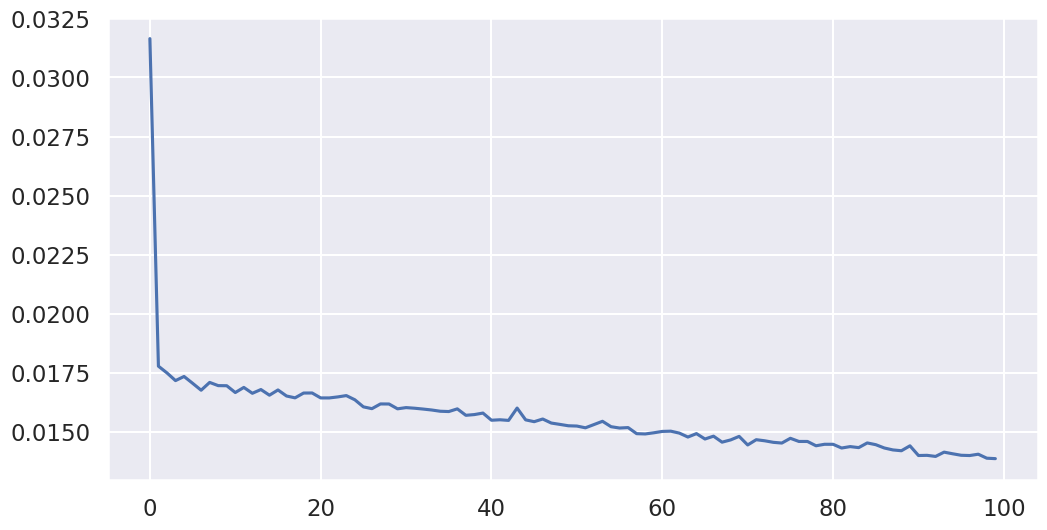

In [7]:
sns.set(context="talk")
# sns.set(context="talk"): Seabornライブラリを使用し、プロットの外観やスタイルを設定しています。
# context="talk"は、プロットのコンテキスト（スタイル）を設定するための指定です。この設定により、プロットが視覚的により魅力的に表示されることがあります。

fig = plt.subplots(figsize=(12,6))
# plt.subplots(figsize=(12,6)): Matplotlibを使用して、新しいプロット（図）を作成します。
# figsizeパラメータは、プロットのサイズを指定するためのもので、ここでは幅12インチ、高さ6インチのプロットを作成しています。

plt.plot(history.history['loss'])
# plt.plot(history.history['loss']): Matplotlibを使用して、訓練中のモデルの損失をプロットしています。
# history.history['loss']は、モデルの訓練中にエポックごとに記録された損失の履歴を示します。plt.plot()はこれらの損失値を折れ線グラフとしてプロットします。
# このコード全体は、機械学習モデルの訓練中に損失がどのように変化するかを視覚化するために使用されます。通常、エポックごとの損失の変化をモニタリングし、モデルの収束や過学習の兆候を確認するためにプロットされます。

# 以下は損失関数の推移が確認できる(5周目ぐらいで収束していることが確認できる)

### 予測

1/1 [==============================] - 0s 55ms/step


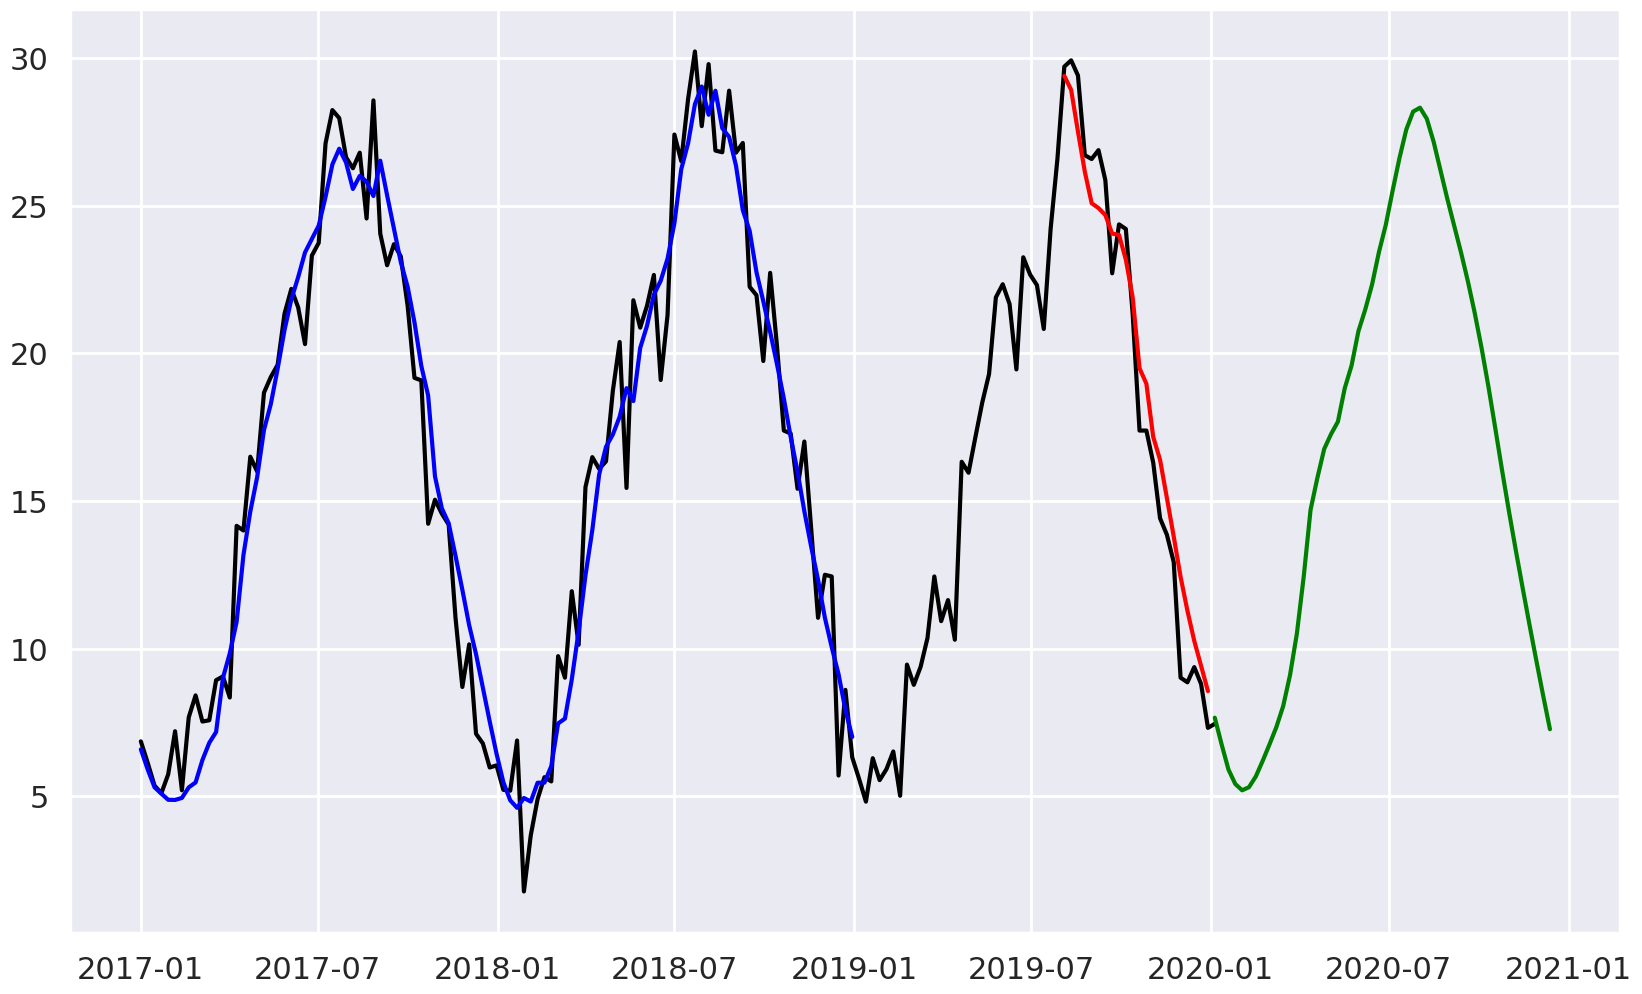

In [8]:
# sns.set(context="poster",font="Hiragino Maru Gothic Pro")
sns.set(context="poster")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
# scaler.inverse_transform(df_week_scale): df_week_scaleで0-1にスケールされているから元のデータに戻す必要がある(scaler.inverse_transform()) -> これで元に戻る
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]['Average Temperature (℃)'],color="black") # 黒が正解のプロット, 2017というには横長になるから

#学習用データ予測結果のプロット(学習したデータだから、おおよそ当たらないと困る)
# model.predict(X_train): 学習データを予測している
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]['Average Temperature (℃)'],color="blue") # 青が学習用データ予測結果のプロット

#評価用データ予測結果のプロット(学習していない部分での予測, これがあっていればそこそこ信頼できる)
# model.predict(X_test): テストデータを予測している
# 31周から予測している
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]['Average Temperature (℃)'],color="red") # 赤が評価用データ予測結果のプロット

#未来予測
future_steps = 50 # 何週間先を予測するか, 未来なればなるほど予測精度が落ちる(右行けば行くほど予測したもので予測することになるから予測精度が落ちる)
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]

df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]['Average Temperature (℃)'],color="green") # 緑が予測したもの

# ぱっと見だとうまく予測しているように思われる(平均気温の場合, 日照時間や洪水量の予測は難しいが、パラメータをしっかり調整すれば良い予測結果が出る)
# ここまでのパラメータは適当だから探索する必要がある

1/1 [==============================] - 0s 45ms/step


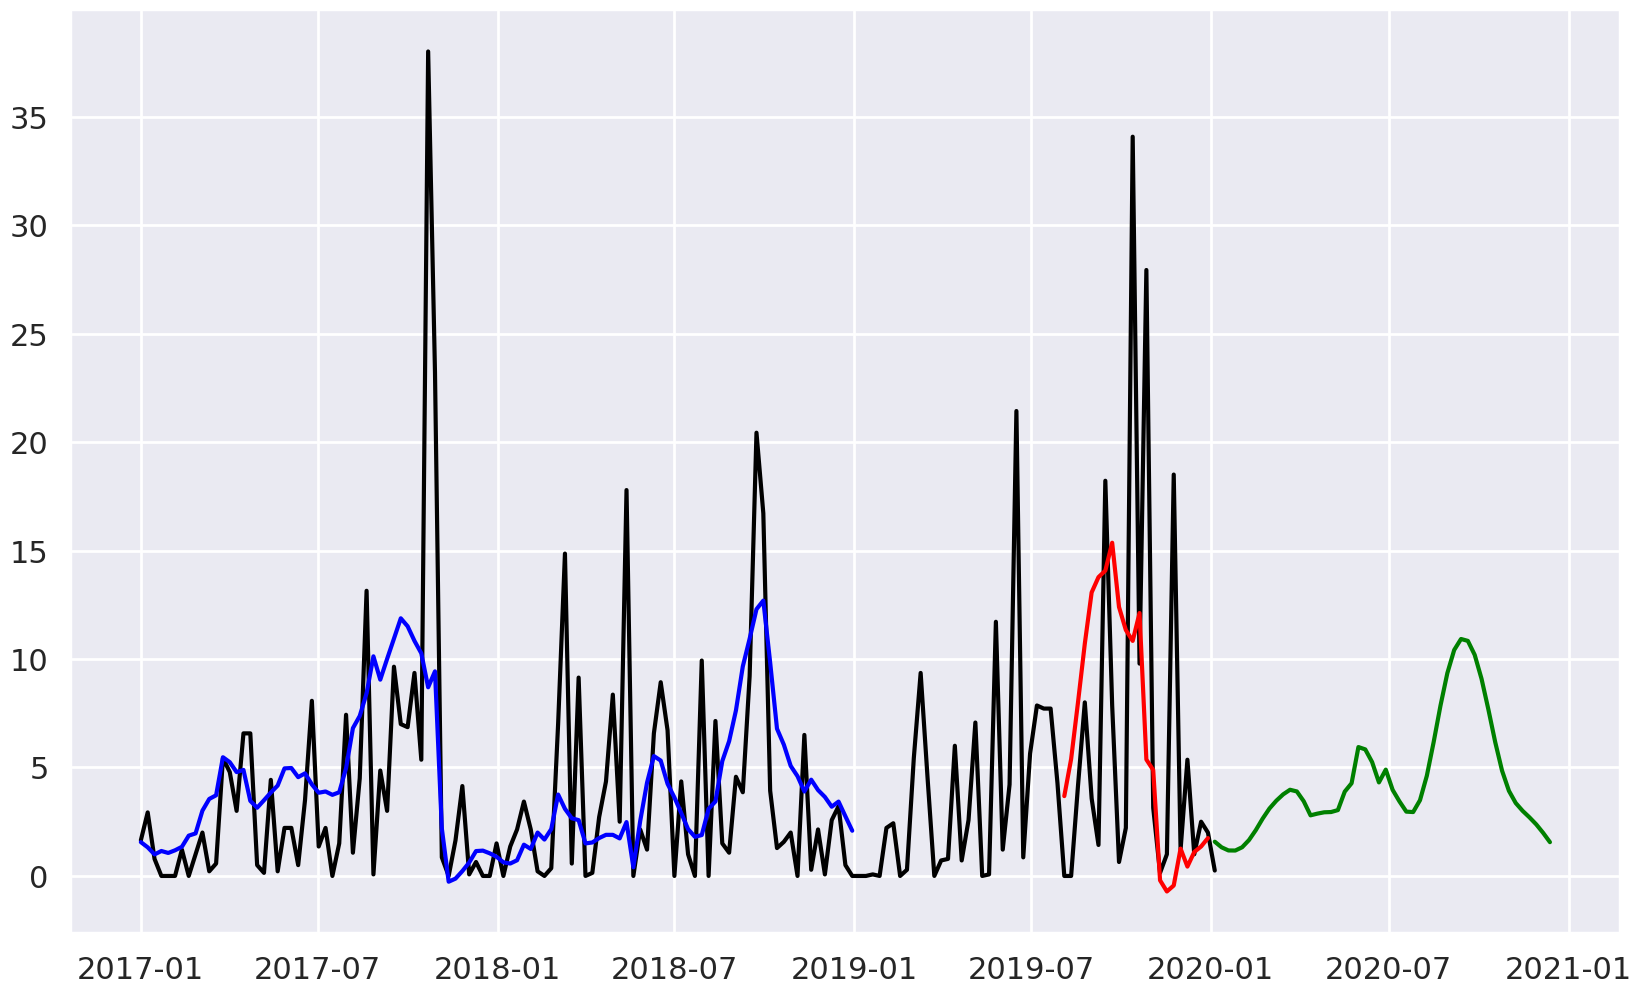

In [9]:
# sns.set(context="poster",font="Hiragino Maru Gothic Pro")
sns.set(context="poster")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
# scaler.inverse_transform(df_week_scale): df_week_scaleで0-1にスケールされているから元のデータに戻す必要がある(scaler.inverse_transform()) -> これで元に戻る
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]['Total Precipitation (mm)'],color="black") # 黒が正解のプロット, 2017というには横長になるから

#学習用データ予測結果のプロット(学習したデータだから、おおよそ当たらないと困る)
# model.predict(X_train): 学習データを予測している
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]['Total Precipitation (mm)'],color="blue") # 青が学習用データ予測結果のプロット

#評価用データ予測結果のプロット(学習していない部分での予測, これがあっていればそこそこ信頼できる)
# model.predict(X_test): テストデータを予測している
# 31周から予測している
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]['Total Precipitation (mm)'],color="red") # 赤が評価用データ予測結果のプロット

#未来予測
future_steps = 50 # 何週間先を予測するか, 未来なればなるほど予測精度が落ちる(右行けば行くほど予測したもので予測することになるから予測精度が落ちる)
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]

df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]['Total Precipitation (mm)'],color="green") # 緑が予測したもの

# ぱっと見だとうまく予測しているように思われる(平均気温の場合, 日照時間や洪水量の予測は難しいが、パラメータをしっかり調整すれば良い予測結果が出る)
# ここまでのパラメータは適当だから探索する必要がある
# 赤の洪水量がマイナスなのはダメ

1/1 [==============================] - 0s 41ms/step


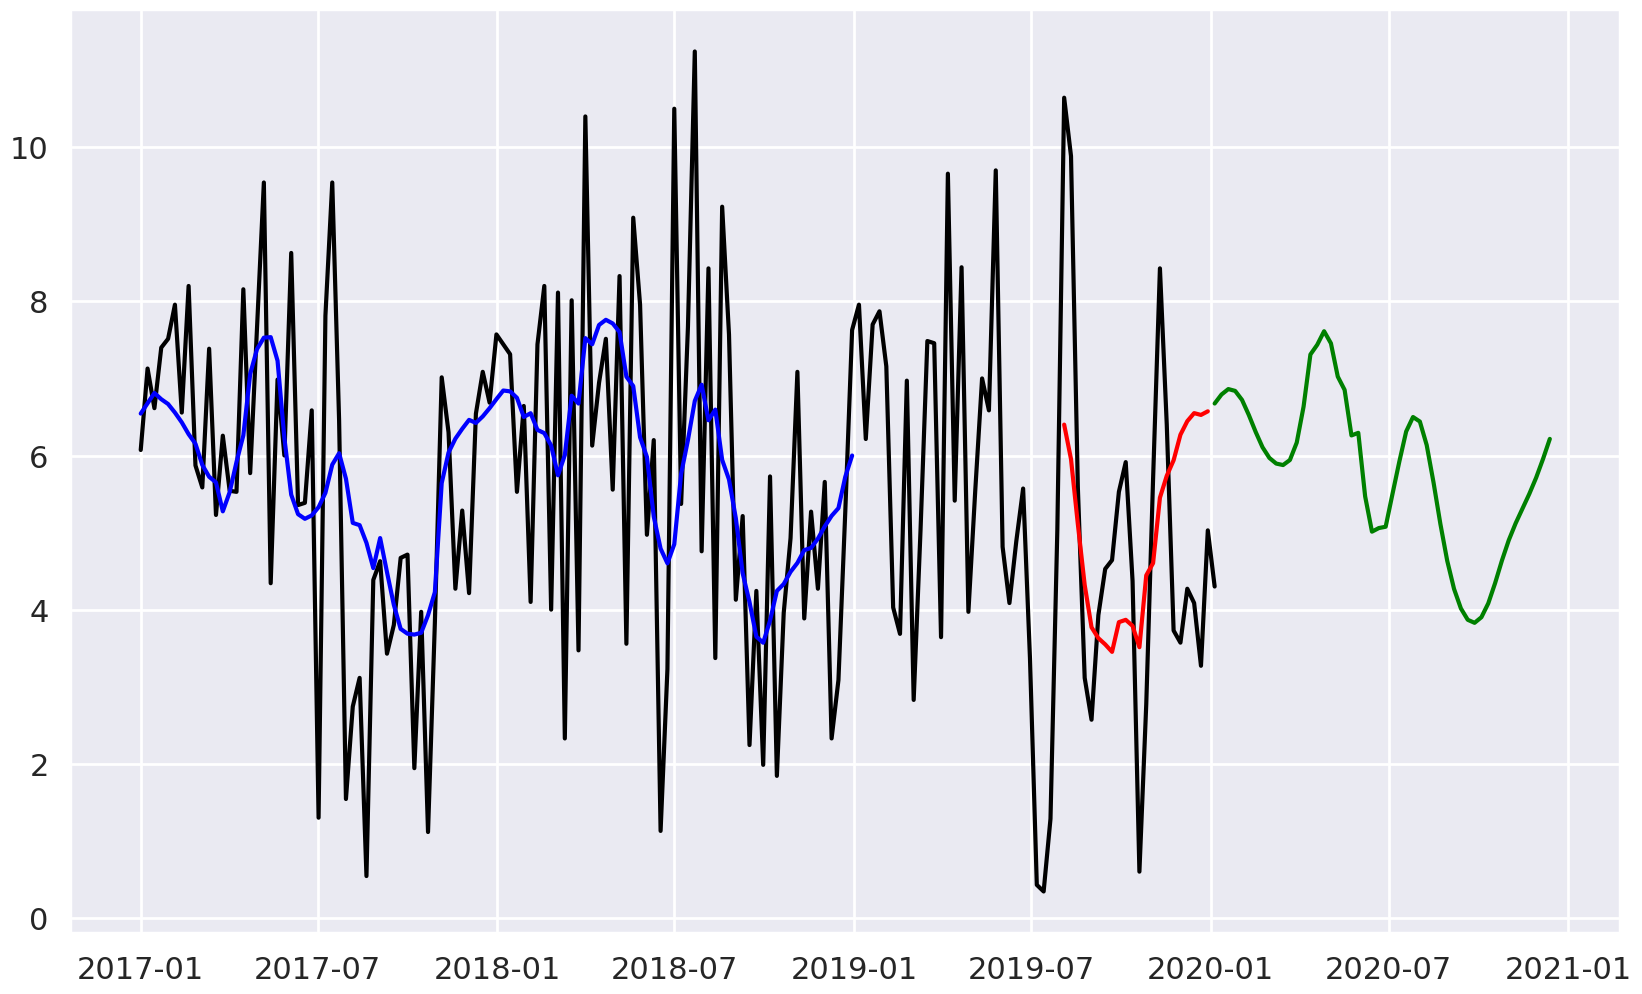

In [10]:
# sns.set(context="poster",font="Hiragino Maru Gothic Pro")
sns.set(context="poster")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
# scaler.inverse_transform(df_week_scale): df_week_scaleで0-1にスケールされているから元のデータに戻す必要がある(scaler.inverse_transform()) -> これで元に戻る
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2017":]['Sunshine Duration (hours)'],color="black") # 黒が正解のプロット, 2017というには横長になるから

#学習用データ予測結果のプロット(学習したデータだから、おおよそ当たらないと困る)
# model.predict(X_train): 学習データを予測している
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2017":]['Sunshine Duration (hours)'],color="blue") # 青が学習用データ予測結果のプロット

#評価用データ予測結果のプロット(学習していない部分での予測, これがあっていればそこそこ信頼できる)
# model.predict(X_test): テストデータを予測している
# 31周から予測している
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2017":]['Sunshine Duration (hours)'],color="red") # 赤が評価用データ予測結果のプロット

#未来予測
future_steps = 50 # 何週間先を予測するか, 未来なればなるほど予測精度が落ちる(右行けば行くほど予測したもので予測することになるから予測精度が落ちる)
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]

df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2017":]['Sunshine Duration (hours)'],color="green") # 緑が予測したもの

# ぱっと見だとうまく予測しているように思われる(平均気温の場合, 日照時間や洪水量の予測は難しいが、パラメータをしっかり調整すれば良い予測結果が出る)
# ここまでのパラメータは適当だから探索する必要がある